<a href="https://colab.research.google.com/github/este7734/in_domain_transfer_learning/blob/master/Model_v2_crosscategorical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Dependencies

In [1]:
import tensorflow as tf
import matplotlib.pylab as plt

import tensorflow_hub as hub
#import tensorflow_datasets as tfds

from tensorflow.keras import layers
import numpy as np

# To parse file names for tensor generations
# and help count files in each directory
import glob
# To move files into new folder structure
import shutil
# For manipulating file paths
import os

# To add colored text to your print outs
from termcolor import colored

# To get python version number that you're running
from platform import python_version

# To save the final model with a time stamp
import time

In [2]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [3]:
from PIL import Image
# Increase the max pixel limit to avoid getting a DecompressionBombWarning from
# PIL and prevent the warning from interupting the training epochs
Image.MAX_IMAGE_PIXELS = 1024 * 1024 * 1024 //5

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Query System Specs

---



In [ ]:
#@title Retrieve Hardware, OS, and Software Specs

print("\n--------Software---------")
print('Python', python_version())
print("\n--------Libraries---------")
print('TensorFlow' , tf.__version__)
print('TensorFlow Hub' , hub.__version__)
# print('Keras v' , layers.__version__)
#print('Glob', glob.__version__)
#print('Shutil', shutil.__version__)
print('matplotlib.pylab', plt.__version__)
print('Numpy', np.__version__)
print('PIL', PIL.__version__)

print("\n--------Operating System------------------------")
!cat /etc/os-release
print("\n--------CPU Specs------------------------")
!lscpu

print("\n--------GPU Specs------------------------")
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('\nYour runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))



--------Software---------
Python 3.6.9

--------Libraries---------
TensorFlow 2.2.0-rc3
TensorFlow Hub 0.8.0
matplotlib.pylab 1.18.3
Numpy 1.18.3

--------Operating System------------------------
NAME="Ubuntu"
VERSION="18.04.3 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.3 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic

--------CPU Specs------------------------
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
St

## Copy data sets from Google Drive to the local instance
Need to Import PyDrive to authorize Colab to your Google Drive Folder

---


*PyDrive is a wrapper library of google-api-python-client that simplifies many common Google Drive API tasks. For this exercise, this allows you to authorize (allows Google Cloud SDK to edit/modify files in your Google Drive) COLAB to access your Google Drive and makes some common tasks such as content fetching very easy.*

Note: This The solution utilizes Google Drive API (official doc) for proper authorization.


---


**Steps:**
1.   Save your `test_set.zip` file to Google Drive - you should have that since you're already using Colab
2.   Right click on it, "Get shareable link", copy the part between `/d/` and `/view?...` - the file id assigned by Google Drive.
    *   In this example: `https://drive.google.com/file/d/1U3owkzT6AvLewTaOWfgwV__BXHDxehDS/view?usp=sharing` 
    *   your file ID is: `1U3owkzT6AvLewTaOWfgwV__BXHDxehDS`

3.   Navigate to the training data link: and download the training data to the local instance
4.   Add and run the following code snippets to your Colab notebook:

---







In [4]:
# Import package to use Google Drive API - not installed in Colab VM by default
from pydrive.auth import GoogleAuth
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
# Other necessary packages
from google.colab import auth
from oauth2client.client import GoogleCredentials
from tensorflow.keras.callbacks import ModelCheckpoint

## Load Training Data

In [5]:
# Follow prompt in the authorization process

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [8]:
# load training data set to your local intance by pulling it from your Google Drive
# to get your file ID from the shareable link in Google Drive, see notes above

file_id =  '1Pg-mK7AY3dATEgfpFcFNXHS9uPus6m9o'  
file_name = 'Combined_storage_tank.zip'  # Change this to your file  

#file_id =  ''  
#file_name = 'Combined_oil_or_gas_fac.zip'  # Change this to your file       

#file_id =  '1o2QB2ylUzzI0k_BdUzr3k_emE3vCl_RI'  
#file_name = 'Combined_helo.zip'  # Change this to your file                               
                                                    
your_file = drive.CreateFile({"id": file_id})
your_file.GetContentFile(file_name)          # Save the file to Colab VM

## Load Test Data

In [ ]:
# load test data set to your local intance by pulling it from your Google Drive
# to get your file ID from the shareable link in Google Drive, see notes above

file_id_test =  '12adH2oV_oigI7LjVvJFgTh9u6_sieLdb'  
file_name_test = 'Combined_storage_tank_test.zip'  # Change this to your file      

#file_id_test =  ''  
#file_name_test = 'Combined_oil_or_gas_fac_test.zip'  # Change this to your file      

#file_id =  '1dQ5GREFcqjvNMmn6y1GFfOUiLMe03kyV'  
#file_name_test = 'Combined_helo_test.zip'  # Change this to your file                               
                                                    
your_file = drive.CreateFile({"id": file_id_test})
your_file.GetContentFile(file_name_test)          # Save the file to Colab VM

In [ ]:
# Unzip Training, Validation, and Test files
!unzip {file_name} 
!unzip {file_name_test} 
#Verify that all the necessary python files and training data files are in your local instance
%ls

In [ ]:
# Instantiate test file path for runing predictions
test_path = '/content/Combine_storage_tank_test'

#test_path = '/content/Combine_oil_or_gas_fac_test'

#test_path = '/content/Combined_helo_test'

# Generate list of images files and count them
# Image totals are used in setting steps per epoch
test_files = glob.glob(test_path + '/*/*.jpg')
test_image_count = len(test_files)
print(f'Total test images: {test_image_count}')

Total test images: 1589


##<font color="cyan"> Establish Data Pipeline </font>


---



Got this from Medium article:
https://towardsdatascience.com/tf-data-creating-data-input-pipelines-2913461078e2

Stanford Tutorial:
https://cs230.stanford.edu/blog/datapipeline/#building-an-image-data-pipeline

---




In [11]:
# Import keras and set image rescaling factor 
# this is without data augmentation
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator( 
        rescale=1./255)

val_datagen = ImageDataGenerator( 
        rescale=1./255)

Using TensorFlow backend.


In [13]:
# Instantiate training and validation file paths

train_path = '/content/Combine_storage_tank/train'
val_path =  '/content/Combine_storage_tank/val'

#train_path = '/content/Combined_oil_or_gas_fac/train'
#val_path =  '/content/Combined_oil_or_gas_fac/val'

#file_id =  '1S32lbB3QIJzWgS07y81VJdzodRz06m9m'  
#file_name = 'Combined_train_val_helo.zip'  # Change this to your file    

#train_path = '/content/Combined_helo/train'
#val_path =  '/content/Combined_helo/val'

# Generate list of images files and count them
# Image totals are used in setting steps per epoch
train_files = glob.glob(train_path + '/*/*.jpg')
train_image_count = len(train_files)
print(f'Total training images: {train_image_count}')

val_files = glob.glob(val_path + '/*/*.jpg')
val_image_count = len(val_files)
print(f'Total validation images: {val_image_count}')

Total training images: 10887
Total validation images: 2721


In [14]:
IMG_RES = 224
BATCH_SIZE = 32

print('Training Set:')
train_set = train_datagen.flow_from_directory(
         train_path,
         shuffle=True,
         target_size=(IMG_RES,IMG_RES),
         batch_size=BATCH_SIZE,
         class_mode='binary')  
         #class_mode='categorical') 

classes = train_set.class_indices # captueres class indicies in a dictionary. For example: {'non_tgt': 0, 'oil_or_gas_fac': 1}

print('Validation Set:')
val_set = val_datagen.flow_from_directory(
         val_path,
         target_size=(IMG_RES,IMG_RES),
         batch_size=BATCH_SIZE,
         class_mode='binary')   
         #class_mode='categorical')        

Training Set:
Found 10887 images belonging to 2 classes.
Validation Set:
Found 8537 images belonging to 2 classes.


## Plot Sample Images to verify status of Data Pipeline

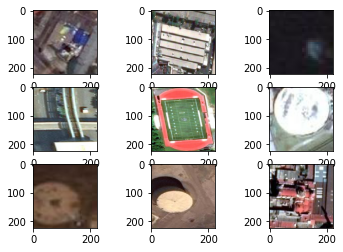

In [15]:
# create a grid of 3*3 images to visualize some of the imgaes in dataset
for i in range(0, 9):
    plt.subplot(330 + 1+ i)
    img = train_set[0][0][i]
    plt.imshow(img)
    
# show the plot
plt.show()

In [16]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

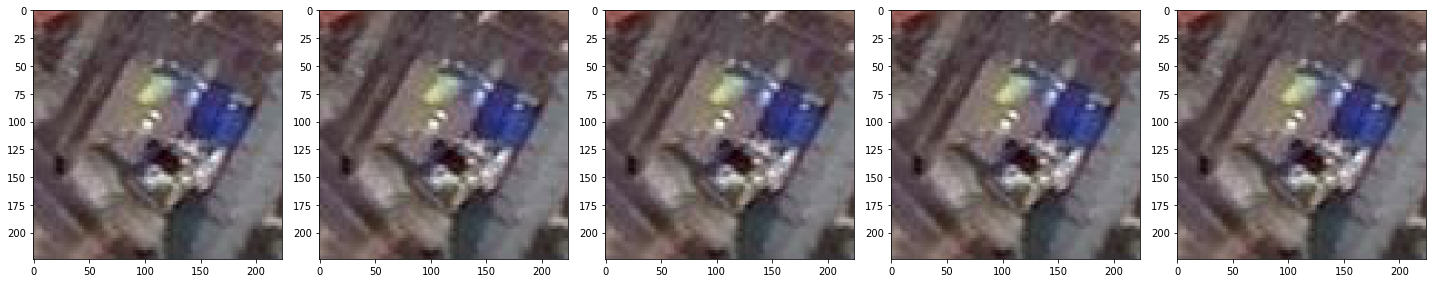

In [17]:
augmented_images = [train_set[0][0][0] for i in range(5)]
plotImages(augmented_images)

# <font color='lightblue'> EuroSat Feature Extractor </font>

Pull in Feature Extractor from TensorFlow Hub

In [18]:
URL = "https://tfhub.dev/google/remote_sensing/uc_merced-resnet50/1"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMG_RES, IMG_RES,3))

Freeze Variables in feature extractor layer so that only training only modifies the final classification layer.

In [19]:
feature_extractor.trainable = False

### <font color='orange'> Double Object Training - Binary Classifier </font>





Attach Classification Head
Source: l06c01_tensorflow_hub_and_transfer_learning (2 x Classes: cats|dogs)

https://colab.research.google.com/drive/1hPyFkWXN6hd_DIjG83b2Vfxfwua9Imho#scrollTo=mGcY27fY1q3Q

<font color='skyblue'> **SparseCategoricalCrossentropy** </font>

---


In [20]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(2, activation='softmax') ### added Softmax activation here in attempt get usable outputs for prediction below
  #layers.Dense(2) 
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23588821  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,592,919
Trainable params: 4,098
Non-trainable params: 23,588,821
_________________________________________________________________


Compile the Model


In [21]:
len(train_set)

341

In [22]:
model.compile(
  optimizer='adam',
  #loss='categorical_crossentropy',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
  metrics=['accuracy'])

Train the Model


In [23]:
print(val_image_count)

2721


In [24]:
# Without Callbacks - Runs Much faster
#from tensorflow.keras.callbacks import ModelCheckpoint
#filepath='/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/weights_best.hdf5'
#checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
#callbacks_list = [checkpoint]

EPOCHS = 30

history = model.fit_generator(
          train_set, 
          steps_per_epoch=int(np.ceil(train_image_count / float(BATCH_SIZE))),
          #steps_per_epoch=train_image_count,
          epochs=EPOCHS,
          validation_data=val_set,
          validation_steps=int(np.ceil(val_image_count / float(BATCH_SIZE)))
          #validation_steps=val_image_count
)         

Epoch 1/30
341/341 [==============================] - 57s 166ms/step - loss: 0.3853 - accuracy: 0.9277 - val_loss: 0.3920 - val_accuracy: 0.9226
Epoch 2/30
341/341 [==============================] - 52s 152ms/step - loss: 0.3666 - accuracy: 0.9454 - val_loss: 0.3536 - val_accuracy: 0.9571
Epoch 3/30
341/341 [==============================] - 54s 158ms/step - loss: 0.3604 - accuracy: 0.9522 - val_loss: 0.3440 - val_accuracy: 0.9680
Epoch 4/30
341/341 [==============================] - 51s 150ms/step - loss: 0.3580 - accuracy: 0.9544 - val_loss: 0.3470 - val_accuracy: 0.9662
Epoch 5/30
341/341 [==============================] - 52s 154ms/step - loss: 0.3543 - accuracy: 0.9589 - val_loss: 0.3484 - val_accuracy: 0.9644
Epoch 6/30
341/341 [==============================] - 49s 143ms/step - loss: 0.3530 - accuracy: 0.9601 - val_loss: 0.3454 - val_accuracy: 0.9709
Epoch 7/30
341/341 [==============================] - 53s 157ms/step - loss: 0.3497 - accuracy: 0.9646 - val_loss: 0.3439 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


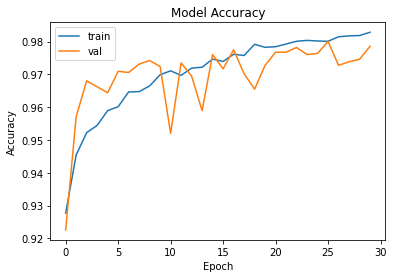

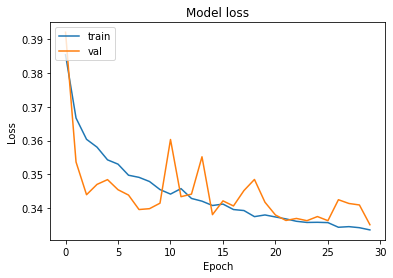

In [25]:
# Plotting the Loss and Classification Accuracy
model.metrics_names
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Part 3: Save Models and Reload

---

https://colab.research.google.com/github/tensorflow/examples/blob/master/courses/udacity_intro_to_tensorflow_for_deep_learning/l07c01_saving_and_loading_models.ipynb#scrollTo=tCnNWTkZ3Ckz




To Save the best version of the model and recall it go here:

https://classroom.udacity.com/courses/ud187/lessons/b091f1a2-1775-4f41-b63b-49ee3d4ec1a1/concepts/d6bd7497-7b20-4cf0-b1b3-314bf3d88fee

Part 3: Save as Keras `.h5` model

Now that we've trained the model,  we can save it as an HDF5 file, which is the format used by Keras. Our HDF5 file will have the extension '.h5', and it's name will correspond to the current time stamp.

In [30]:
#@title Save Model

t = time.time()
model_name = input('Enter model name: ')
# Extract name of original dataset from the training file path 
# to use in naming the saved model
model_path = train_path.split('/')[-2]

# Export the trained model and save it to local instance
export_path_keras = f'{int(t)}_{model_path}_{model_name}_h5_model_.h5'
#export_path_keras = "{}_h5_model{}_{}.h5".format(model_name, int(t), model_path) 
print(f'Model saved to local instance here: {export_path_keras}')
# Save model
model.save(export_path_keras)

# Export the trained model and save it to Google Drive
google_drive_path = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/' 
export_path_keras = f'{google_drive_path}{int(t)}_{model_path}{model_name}_h5_model.h5'
print(f'Model saved to Google Drive here: {export_path_keras}')
# Save model
model.save(export_path_keras)
print(f'Model saved here: {export_path_keras}')

!ls

Enter model name: Run_1_
Model saved to local instance here: 1594079818_Combine_storage_tank_Run_1__h5_model_.h5
Model saved to Google Drive here: /content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594079818_Combine_storage_tankRun_1__h5_model.h5
Model saved here: /content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/1594079818_Combine_storage_tankRun_1__h5_model.h5
1594079493_Combine_storage_tank_Storage_Tank_Model_v2_crosscategorical_h5_model_.h5
1594079633_Combine_storage_tank_Storage_Tank_Model_v2_crosscategorical__h5_model_.h5
1594079818_Combine_storage_tank_Run_1__h5_model_.h5
adc.json
Combined_storage_tank.zip
Combine_storage_tank
drive
__MACOSX
sample_data


Reload Previously Trained Model - <font color='orange'> Skip this code block using model trained during this session!!!</font>


---



In [ ]:
#@title Open this to reload previously trained model (not during this session)
# Follow prompt in the authorization process

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#@title Open this to reload previously trained model (not during this session)
# Enter the path and filename for the trained model here
export_path_keras = '/content/drive/My Drive/Colab Notebooks/Thesis Resources/Training_Sessions/trained_models/Model_v2_success_1593962354_Combined_helo.h5'

# Copy trained model to local instance
export_path_keras = shutil.copyfile(export_path_keras, os.path.join('/content/' + export_path_keras.split('/')[-1]))
print(export_path_keras)

In [31]:
reloaded = tf.keras.models.load_model(
  export_path_keras, 
  # `custom_objects` tells keras how to load a `hub.KerasLayer`
  custom_objects={'KerasLayer': hub.KerasLayer})

reloaded.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              23588821  
_________________________________________________________________
dense (Dense)                (None, 2)                 4098      
Total params: 23,592,919
Trainable params: 4,098
Non-trainable params: 23,588,821
_________________________________________________________________


## Run Predictions on Test Set

---



In [43]:
from keras.preprocessing import image
prediction_list = []

for i in range(len(test_files)):
  test_image = image.load_img(test_files[i], target_size= (IMG_RES, IMG_RES))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  result = reloaded.predict(test_image) # there is something wrong with this... seems it isn't supposed to take one image at at time... needs an array
  result = tf.squeeze(result).numpy() # removes the extra dimension in tensor (basically extracts the contents of result prediction tuple)
  # Delete below if it doesn't work
  result = np.argmax(result, axis=-1)
  prediction_list.append(result)
out_list = dict(zip(test_files, prediction_list))

## Troubleshooting Predictions

In [44]:
# Out_list with TF function and softmax activation on output layer
out_list

{'/content/Combine_storage_tank_test/tst_non_tgt/c_t_0009676_9_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0004301_0_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0002543_0_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0011684_0_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0006754_0_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0009796_5_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0009985_5_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0006627_1_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0000249_17_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0009741_3_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0007385_4_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0003114_0_rgb.jpg': 0,
 '/content/Combine_storage_tank_test/tst_non_tgt/c_t_0000235_0_rgb.jpg': 0,
 '/content/

In [ ]:
from keras.preprocessing import image

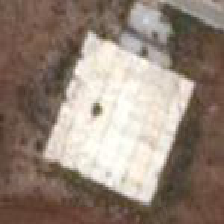

In [ ]:
test_image = image.load_img(test_files[45], target_size= (IMG_RES, IMG_RES))
test_image

In [ ]:
test_image = image.img_to_array(test_image)
test_image

In [ ]:
test_image = np.expand_dims(test_image, axis = 0)
test_image

In [ ]:
result = reloaded.predict(test_image)
result

array([[0., 1.]], dtype=float32)

In [ ]:
 result1 = tf.squeeze(result).numpy()
 result1

array([0., 1.], dtype=float32)

In [ ]:
result1 = np.argmax(result1, axis=-1)
result1

1

In [ ]:
b = np.argmax(([1650.6642, 1146.8196]), axis=-1)
b

0

In [ ]:
type(out_list)

dict

In [ ]:
# Out_list with TF function and softmax activation on output layer
out_list

## Pandas DF For Reference

---


*Thanks to [PurpleDin0](https://github.com/PurpleDin0) and [jeffpier](https://github.com/jeffpier) for the prediction decoder loop to Pandas dataframe below. Thier full code can be found on GitHub [here.](https://github.com/PurpleDin0/CNN-exercise/blob/master/MST698S_BOG_CNN_exercise-execution_notebook.ipynb)*

In [46]:
import pandas as pd
#pd.DataFrame(out_list)
out_list_fixed = {}
out_list_actual = {}
for i, key in enumerate(out_list):
    out_list_fixed[key] = int(out_list[key]) #converts the tank predication to an integer
    if '/tst_non_tgt/' in key:
        out_list_actual[key] = 0
    elif '/tst_storage_tank/' in key:
        out_list_actual[key] = 1
    else:
      print('SOMETHING BROKE ... WHAT DID YOU DO!')
df_predicted = pd.DataFrame.from_dict(out_list_fixed, orient='index', columns=['predicted'])
df_actual = pd.DataFrame.from_dict(out_list_actual, orient='index', columns=['actual'])

In [49]:
df_results = pd.concat([df_predicted, df_actual], axis=1)
df_results

,predicted,actual
/content/Combine_storage_tank_test/tst_non_tgt/c_t_0009676_9_rgb.jpg,0,0
/content/Combine_storage_tank_test/tst_non_tgt/c_t_0004301_0_rgb.jpg,0,0
/content/Combine_storage_tank_test/tst_non_tgt/c_t_0002543_0_rgb.jpg,0,0
/content/Combine_storage_tank_test/tst_non_tgt/c_t_0011684_0_rgb.jpg,0,0
/content/Combine_storage_tank_test/tst_non_tgt/c_t_0006754_0_rgb.jpg,0,0
...,...,...
/content/Combine_storage_tank_test/tst_storage_tank/c_t_0009936_2_rgb.jpg,0,1
/content/Combine_storage_tank_test/tst_storage_tank/c_t_0002375_0_rgb.jpg,0,1
/content/Combine_storage_tank_test/tst_storage_tank/c_t_0010668_3_rgb.jpg,0,1
/content/Combine_storage_tank_test/tst_storage_tank/c_t_0009355_0_rgb.jpg,0,1


## MCC Calculation

In [50]:
#Import the required functions
from sklearn.metrics import confusion_matrix, matthews_corrcoef
import math

In [51]:
#Build the confusion matrix
matrix = confusion_matrix(df_results.actual.values.tolist(), df_results.predicted.values.tolist())
print(f'Confustion Matrix\n {matrix}\n')

# Print MCC
MCC = matthews_corrcoef(df_results.actual.values.tolist(), df_results.predicted.values.tolist())
print(f'\nMCC:\n{MCC}')


Confustion Matrix
 [[866   0]
 [720   3]]


MCC:
0.04759911008744184


In [ ]:
TP = matrix[0][0]
TN = matrix[1][1]
FP = matrix[0][1]
FN = matrix[1][0]
print(f'Not_Tank | Tank')
print('='*20)
print(f'TP: {TP} | FP: {FP}')
print(f'FN: {FN} | TN: {TN}')

Not_Tank | Tank
TP: 1 | FP: 566
FN: 0 | TN: 866


Calculate MCC by hand

![alt text](https://miro.medium.com/max/1400/1*8E2rPn_ccOqGuPYj1gBTAg.png
)

In [ ]:
MCC_calc = (TP*TN - FP*FN)/(math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)))
print(f'Difference between Sklearn MCC and manual MCC = {MCC_calc - MCC}')

Difference between Sklearn MCC and manual MCC = 0.0


# Stats Tracker

---



In [ ]:
tng_stats.drop_duplicates

<bound method DataFrame.drop_duplicates of    Unnamed: 0  batch  epochs  ...  tng_acc  val_acc  total_tng_time
0           0    100      30  ...   0.2998   0.3327            4:15
1           1    100      30  ...   0.2998   0.3327            4:15

[2 rows x 8 columns]>

In [ ]:
import math

tng_time = [5794, 351, 352, 351, 346, 354, 350, 357, 348, 360, 350, 354, 347, 351, 352, 354, 345, 361, 342, 369, 355, 347, 350, 354, 361, 346, 355,347]
t_time = round(sum(tng_time)/60/60, 2)

hr = math.floor(t_time)
m = round((t_time - hr)*60)
m = '%02d' % m

train_time = str(hr) + ':' + m
print(f'Total Training Time: {train_time}')

Total Training Time: 4:15


In [ ]:
tng_loss = round(history.history['loss'][len(history.history)], 4)
val_loss = round(history.history['val_loss'][len(history.history)], 4)

print(f'Train Loss: {tng_loss}')
print(f'Val Loss: {val_loss}')

tng_acc = round(history.history['accuracy'][len(history.history)], 4)
val_acc = round(history.history['val_accuracy'][len(history.history)], 4)

print(f'Train Accuracy: {tng_acc}')
print(f'Val Accuracy: {val_acc}')

Train Loss: 0.5878
Val Loss: 0.6212
Train Accuracy: 0.2998
Val Accuracy: 0.3327


In [ ]:
import pandas as pd
import numpy as np

Export DF to CSV

---
https://towardsdatascience.com/how-to-export-pandas-dataframe-to-csv-2038e43d9c03

`df.to_csv('file_name.csv')`

`df.to_csv('file_name.csv', encoding='utf-8')`

`df.to_csv('file_name.csv', index=False)` Example: `df.to_csv('C:/Users/abc/Desktop/file_name.csv')`


### Create the Training Stats Tracker

In [ ]:
testdf = pd.DataFrame(np.array([[BATCH_SIZE, EPOCHS, tng_loss, val_loss, tng_acc, val_acc, train_time]]), columns=['batch', 'epochs', 'tng_loss', 'test_loss', 'tng_acc', 'val_acc', 'total_tng_time'])
testdf

,batch,epochs,tng_loss,test_loss,tng_acc,val_acc,total_tng_time
0,100,30,0.5878,0.6212,0.2998,0.3327,4:15


### Add Stats to Training Tracker


In [ ]:
testdf.loc[len(testdf)] = [BATCH_SIZE, EPOCHS, tng_loss, val_loss, tng_acc, val_acc, train_time]
testdf

,batch,epochs,tng_loss,test_loss,tng_acc,val_acc,total_tng_time
0,100,30,0.5878,0.6212,0.2998,0.3327,4:15
1,100,30,0.5878,0.6212,0.2998,0.3327,4:15


Write Training Stats to Folder

In [ ]:
file_name = r'/content/drive/My Drive/Colab Notebooks/Thesis Resources/training_stats_Actual.csv'
testdf.to_csv(file_name)

Read In Trianing Tracker CSV

In [ ]:
tng_stats = pd.read_csv(file_name)
tng_stats 

,Unnamed: 0,batch,epochs,tng_loss,test_loss,tng_acc,val_acc,total_tng_time
0,0,100,30,0.5878,0.6212,0.2998,0.3327,4:15
1,1,100,30,0.5878,0.6212,0.2998,0.3327,4:15


# Creating Checkpoints and Loading the Saved Model

---

Look at 4th solution from the bottom for the code. Note: I attempted this on Bailey's CNN and it didn't seem to save the file anywhere: https://stackoverflow.com/questions/45393429/keras-how-to-save-model-and-continue-training

Also from Udacity Lesson: https://colab.research.google.com/drive/134BrZg43NxOcaqn38RUXwdIuRH7ZAq6R (Search "checkpoint)

In [ ]:
#@title May not have time for this - Delete
from keras.callbacks import ModelCheckpoint

# define the checkpoint
filepath = "Trained_Model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

classifier.fit_generator(training_set, steps_per_epoch = train_number, epochs = 25, validation_data = test_set, validation_steps = test_number)
classes = training_set.class_indices